In [5]:
import sys
sys.path.append("..")

import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50
import importlib
import consts
importlib.reload(consts)
from preceding_events import *
from combine_data import filter_short_stays_and_different_unit
from bp_for_dose import get_relevant_doses_with_bp


In [6]:
inputevets_filtered = pd.read_csv("..\\filtered\\input_events_filtered_by_subject_id_and_medicine.csv")
chartevents_filtered = pd.read_csv("..\\filtered\\filtered_chartevents.csv")
icustays_filtered = pd.read_csv("..\\filtered\\filtered_icustays.csv")
patients_filtered = pd.read_csv("..\\filtered\\filtered_patients.csv")
procedureevents_filtered = pd.read_csv("..\\filtered\\filtered_procedureevents.csv")
labevents_filtered = pd.read_csv("..\\filtered\\filtered_labevents.csv")
transfers_filtered = pd.read_csv("..\\filtered\\filtered_transfers.csv")
itemid = pd.read_csv("..\\data\\icu\\d_items.csv")

In [7]:
def generate_equal_size_group(group):
    smaller_size = group["first_careunit"].value_counts().min()
    smaller_gr = group["first_careunit"].value_counts().index[group.first_careunit.value_counts().argmin()]
    bigger_gr = group["first_careunit"].value_counts().index[group.first_careunit.value_counts().argmax()]
    subgroup1 = group[group["first_careunit"] == smaller_gr]
    subgroup2 = group[group["first_careunit"] == bigger_gr].sample(smaller_size)
    return pd.concat([subgroup1, subgroup2], axis=0)

In [8]:
#inputevents_with_bp = get_relevant_doses_with_bp()
inputevents_with_bp = pd.read_csv("temporal_bp_per_dose.csv")
inputevents_with_bp = filter_short_stays_and_different_unit(inputevents_with_bp, icustays_filtered)
inputevents_SICU_MICU = inputevents_with_bp[inputevents_with_bp["first_careunit"].isin(["Medical Intensive Care Unit (MICU)", "Surgical Intensive Care Unit (SICU)"])]

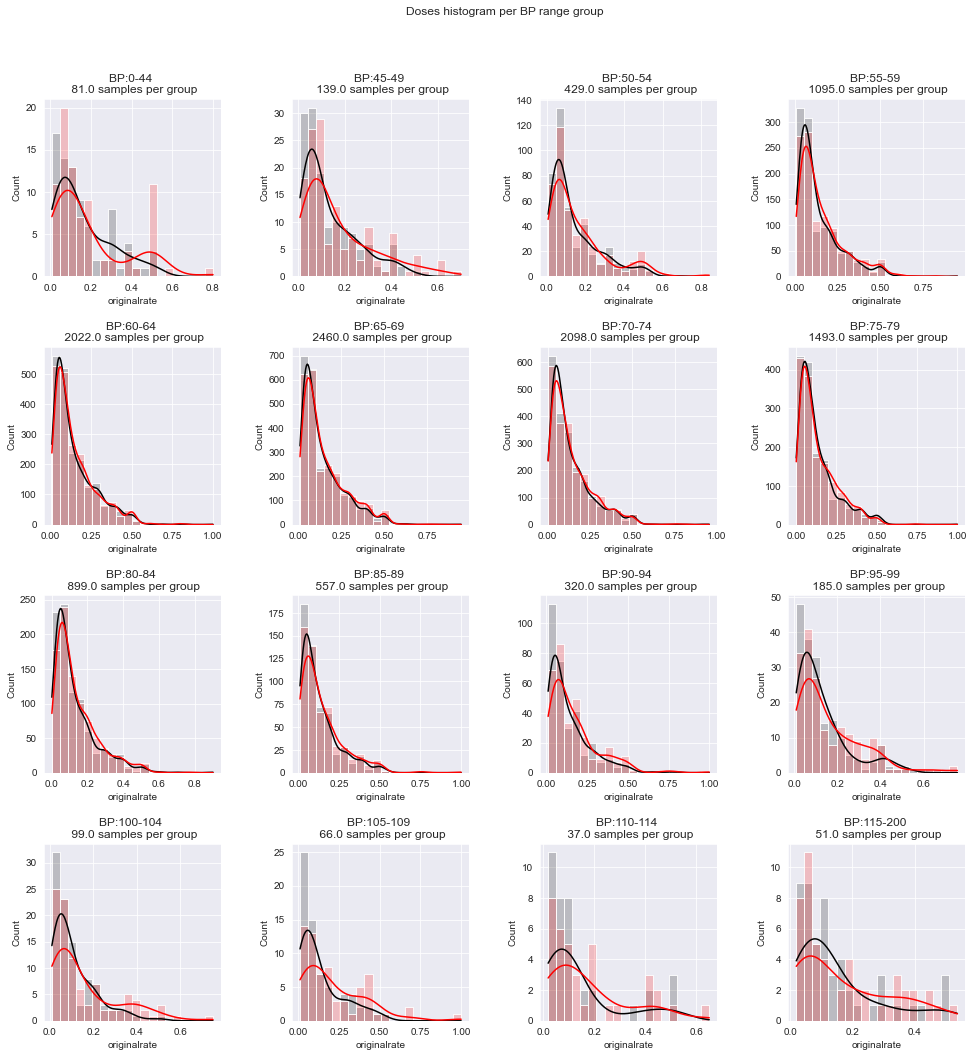

In [30]:
import seaborn as sns
sns.color_palette("Paired")
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(16, 16)
fig.suptitle('Doses histogram per BP range group')
for bp_range, i in zip(consts.BP_RANGES, range(0,16)):
    bp_low, bp_high = bp_range 
    bp_section_events = inputevents_SICU_MICU[(inputevents_SICU_MICU["bp_val"] >= bp_low) & 
                                (inputevents_SICU_MICU["bp_val"] <= bp_high) & 
                                (inputevents_SICU_MICU["originalrate"] <= 1) & 
                                (inputevents_SICU_MICU["originalrate"] >= 0)]
    bp_section_events = generate_equal_size_group(bp_section_events)
    number_of_samples = bp_section_events.shape[0]/2
    sns.histplot(data=bp_section_events[["originalrate", "first_careunit"]],
                x="originalrate",
                bins=20, 
                hue="first_careunit", 
                kde=True, 
                ax=axs[i//4, i%4], 
                legend=False,
                palette={"Surgical Intensive Care Unit (SICU)" : "red", "Medical Intensive Care Unit (MICU)" : "black"},
                alpha=0.2)
    axs[i//4, i%4].set_title(f"BP:{bp_low}-{bp_high} \n {number_of_samples} samples per group")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [10]:
tmp = inputevets_filtered[0:10000]

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
for period, color in zip([0.5, 1, 2],["red","blue", "orange"]):
    counts_lst = []
    for row in range(tmp.shape[0]):
        dose_preceding_results = preceding_events.get_events_beofore_dose(tmp.iloc[row]["starttime"], period, tmp.iloc[row]["subject_id"], chartevents_filtered, "charttime")
        results_count = dose_preceding_results[dose_preceding_results["itemid_label"] != "Heart Rate"].shape[0]
        counts_lst.append(results_count)
        
    sns.histplot(pd.DataFrame(counts_lst), binrange=[0,10], bins=10, color=color)
    plt.title(f"BP events in {str(period)} hour prior to single dose \n statistics of 10,000 doses \n all BP events (Arterial + non invasive)", fontsize=16)
    plt.xlabel(f"BP events in {str(period)} hour")
    plt.savefig(f"plots/BP_events_in_{str(period)}_hour_prior_to_dose.png")
    plt.show()

NameError: name 'preceding_events' is not defined

In [ ]:
pd.DataFrame(counts_lst).value_counts(normalize=True) *100

1     39.9
0     29.0
2     18.9
3      5.0
4      2.4
5      1.3
7      1.0
6      0.9
8      0.5
9      0.4
18     0.2
20     0.2
21     0.2
25     0.1
dtype: float64

In [ ]:
chartevents_filtered[(chartevents_filtered["stay_id"] == 39101627) & (chartevents_filtered["itemid_label"] == "Arterial Blood Pressure mean")]

,Unnamed: 0.1,Unnamed: 0,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,itemid_label
2294611,2294611,11382715,19004463,24357541,39101627,2177-01-14 02:59:00,2177-01-14 03:31:00,220052,88.0,88.0,mmHg,0,Arterial Blood Pressure mean
2294612,2294612,11382719,19004463,24357541,39101627,2177-01-14 03:00:00,2177-01-14 03:31:00,220052,83.0,83.0,mmHg,0,Arterial Blood Pressure mean
2294613,2294613,11382750,19004463,24357541,39101627,2177-01-14 04:00:00,2177-01-14 04:07:00,220052,77.0,77.0,mmHg,0,Arterial Blood Pressure mean
2294614,2294614,11382786,19004463,24357541,39101627,2177-01-14 05:00:00,2177-01-14 05:06:00,220052,91.0,91.0,mmHg,0,Arterial Blood Pressure mean
2294615,2294615,11382811,19004463,24357541,39101627,2177-01-14 06:00:00,2177-01-14 06:06:00,220052,94.0,94.0,mmHg,0,Arterial Blood Pressure mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295279,2295279,11394672,19004463,24357541,39101627,2177-02-10 00:00:00,2177-02-10 00:42:00,220052,111.0,111.0,mmHg,0,Arterial Blood Pressure mean
2295280,2295280,11394713,19004463,24357541,39101627,2177-02-10 01:00:00,2177-02-10 01:21:00,220052,101.0,101.0,mmHg,0,Arterial Blood Pressure mean
2295281,2295281,11394719,19004463,24357541,39101627,2177-02-10 02:00:00,2177-02-10 02:36:00,220052,115.0,115.0,mmHg,0,Arterial Blood Pressure mean
2295282,2295282,11394728,19004463,24357541,39101627,2177-02-10 03:00:00,2177-02-10 03:33:00,220052,111.0,111.0,mmHg,0,Arterial Blood Pressure mean
